In [233]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json 
import csv 
import random 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import regularizers 
from tensorflow.keras.initializers import Constant


import pprint 
import tensorflow.compat.v1 as tf 
from tensorflow.python.framework import ops 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 

In [234]:
data = pd.read_csv("news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [235]:
data.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [236]:
data.shape

(6335, 4)

In [237]:
data = data.drop('Unnamed: 0', axis=1)

In [238]:
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Encoding

In [239]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


<Axes: xlabel='label', ylabel='count'>

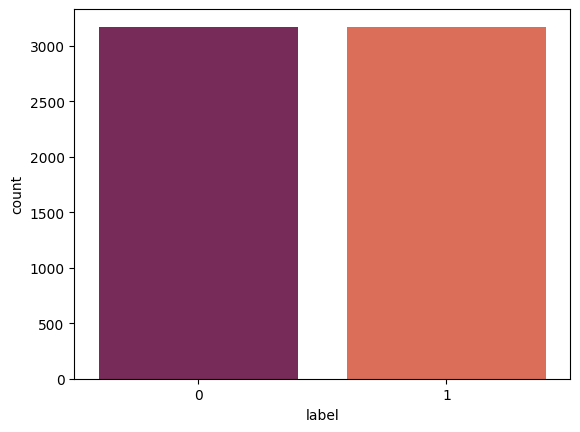

In [240]:
label_map = {0: 'Fake', 1: 'Real'}
sns.countplot(x='label', data=data, palette='rocket')

Params

In [241]:
embedding_dim = 50
max_length = 54
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 3000    # training
test_portion = .1       # testing


In [242]:
# extract data
title = [] 
text = [] 
labels = []
 
for x in range(training_size): 
    title.append(data['title'][x]) 
    text.append(data['text'][x]) 
    labels.append(data['label'][x])

In [243]:
print(len(title))
print(len(text))
print(len(labels))

3000
3000
3000


Tokenization

In [244]:
tokenizer1 = Tokenizer() 
tokenizer1.fit_on_texts(title) 
word_index1 = tokenizer1.word_index 
vocab_size1 = len(word_index1)
 
sequences1 = tokenizer1.texts_to_sequences(title) 

# make sure there the same length
padded1 = pad_sequences(sequences1,  padding=padding_type, truncating=trunc_type) 

In [245]:
split = int(test_portion * training_size)
training_sequences1 = padded1[split:training_size]  # Training data
test_sequences1 = padded1[:split]                   # Testing data
training_labels = labels[split:training_size]       # Training labels
test_labels = labels[:split]                        # Testing labels

Embedding

In [246]:
embeddings_index = {}

# file for predefined vector space for words
with open('glove.6B.50d.txt', encoding='utf-8') as f: 
	for line in f: 
		values = line.split() 
		word = values[0] 
		coefs = np.asarray(values[1:], dtype='float32') 
		embeddings_index[word] = coefs 

# embeddings 
embeddings_matrix = np.zeros((vocab_size1+1, embedding_dim)) 
for word, i in word_index1.items(): 
	embedding_vector = embeddings_index.get(word) 
	if embedding_vector is not None: 
		embeddings_matrix[i] = embedding_vector 

Model

In [247]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size1 + 1, embedding_dim, 
                              input_length=max_length, 
                              embeddings_initializer=Constant(embeddings_matrix), 
                              trainable=False,
                              input_shape=(max_length,)), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Conv1D(64, 5, activation='relu'), 
    tf.keras.layers.MaxPooling1D(pool_size=4), 
    tf.keras.layers.LSTM(64), 
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary() 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'sequential_10/lstm_10/lstm_cell/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\weak_tensor_ops.py", line 88, in wrapper
    return op(*args, **kwargs)  File "c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\ops\numpy_ops\np_array_ops.py", line 316, in diag
    control_flow_assert.Assert(  File "c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\traceback_utils.py", line 155, in error_handler
    del filtered_tb  File "c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\util\dispatch.py", line 1260, in op_dispatch_handler
    return dispatch_

c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 54, 50)         │       377,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 50, 64)         │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,753 (1.63 MB)

 Trainable params: 49,153 (192.00 KB)

 Non-trainable params: 377,600 (1.44 MB)

Training

In [248]:
num_epochs = 50

training_padded = np.array(training_sequences1) 
training_labels = np.array(training_labels) 
testing_padded = np.array(test_sequences1) 
testing_labels = np.array(test_labels)

In [249]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50


c:\Users\adamn\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.